# Курсовая работа № 2
## Аналитика. Начальный уровень

Курсовая работа состоит из двух частей – обязательной и дополнительной. **Для зачета необходимо выполнение только первой части.** Выполнение второй части может потребовать дополнительные знания Python.

- [Часть первая](#Часть-первая)
- [Часть вторая](#Часть-вторая)

## Часть первая


Перед вами стоит задача – подготовить аналитический отчет для HR-отдела. На основании проведенной аналитики предполагается составить рекомендации для отдела кадров по стратегии набора персонала, а также по взаимодействию с уже имеющимися сотрудниками.
<br><br> В базе данных лежит набор таблиц, которые содержат данные о сотрудниках вымышленной компании.
Сделайте обзор штата сотрудников компании. Составьте набор предметов исследования, а затем проверьте их на данных. Вся аналитика должна быть выполена с помощью SQL. Впоследствии данные можно визуализировать, однако финальные датафреймы для графиков также должны быть подготовлены с помощью SQL. <br><br>

Примеры гипотез:
1. Есть зависимость между `perfomance score` и тем, под чьим руководством работает сотрудник.
2. Есть зависимость между продолжительностью работы в компании и семейным положением сотрудника.
2. Есть зависимость между продолжительностью работы в компании и возрастом сотрудника.

<br><br>
Параметры для подключения следующие: хост – `dsstudents.skillbox.ru`, порт – `5432`, имя базы данных – `human_resources`, пользователь – `readonly`, пароль – `6hajV34RTQfmxhS`. Таблицы, доступные для анализа, – `hr_dataset`, `production_staff`, `recruting_costs`, `salary_grid`.

In [1]:
import psycopg2
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
import pymorphy2
from collections import defaultdict

pg_connection = {
    "host": "dsstudents.skillbox.ru",
    "port": 5432,
    "dbname": "human_resources",
    "user": "readonly",
    "password": "6hajV34RTQfmxhS"
}
conn = psycopg2.connect(**pg_connection)

cursor = conn.cursor()



### 1. Есть зависимость ли между perfomance score и тем, под чьим руководством работает сотрудник.

Рассмотрим какие значения есть для оценки производительности и какие perf_scoreid им соответствуют

In [2]:

conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

sql_str = """SELECT DISTINCT "perf_scoreid", "Performance Score"
FROM hr_dataset hr
ORDER BY "perf_scoreid";
"""
conn.commit()
cursor.execute(sql_str)
df_perfscore = [a for a in cursor.fetchall()]

cursor.close()

df_perfscore

[(0, '90-day meets'),
 (1, 'PIP'),
 (2, 'Needs Improvement'),
 (3, 'Fully Meets'),
 (4, 'Exceeds'),
 (5, 'Exceptional'),
 (9, 'N/A- too early to review')]

Как видно чем выше производительность, тем больше значение perf_scoreid, а значит этим можно воспользоваться для вычисления средней оценки производительности труда по каждому менеджеру, необходимо только отфильтровать значения 'N/A- too early to review' и '90-day meets', так как эти оценки не влияют на оценку общей производттельности труда

In [3]:
# создадим датасет на предмет исследования зависимости оценки показателя производительности от менеджера:

conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

sql_str = """
SELECT "Manager Name", ROUND(avg("perf_scoreid"), 2) average
FROM hr_dataset
WHERE  "Performance Score" NOT IN('N/A- too early to review', '90-day meets')
GROUP BY "Manager Name"
ORDER BY average;
"""
conn.commit()
cursor.execute(sql_str)
df_manager_perf_score =pd.DataFrame([a for a in cursor.fetchall()])
df_manager_perf_score.columns = ['manager', 'average']
cursor.close()

df_manager_perf_score

,manager,average
0,Debra Houlihan,2.67
1,John Smith,2.77
2,Michael Albert,2.80
3,Brian Champaigne,3.00
4,Webster Butler,3.00
5,Brannon Miller,3.00
6,Brandon R. LeBlanc,3.00
7,Lynn Daneault,3.00
8,Peter Monroe,3.00
9,Board of Directors,3.00


Видно, что почти у всех менеджеров производительность труда в среднем находится в полном соответствии с нормами, и даже выше, у трёх остальных требует улучшения. Найдём работников этих трёх менеджеров производительность труда которых ниже нормы:

In [4]:
conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

sql_str = """
SELECT "Employee Name", 
        department, 
       "perf_scoreid", 
       "Manager Name"
FROM hr_dataset
WHERE "Manager Name" IN('Debra Houlihan','John Smith', 'Michael Albert') 
       AND perf_scoreid IN(1,2)
ORDER BY "Manager Name";
"""
conn.commit()
cursor.execute(sql_str)
df_three_need_imp_employee =pd.DataFrame([a for a in cursor.fetchall()])
df_three_need_imp_employee.columns = ['employee_name', 'department', 'perf_scoreid', 'manager_name']
cursor.close()

df_three_need_imp_employee

,employee_name,department,perf_scoreid,manager_name
0,"Smith, John",Sales,2,Debra Houlihan
1,"Dietrich, Jenna",Sales,1,John Smith
2,"Mullaney, Howard",Sales,2,John Smith
3,"Estremera, Miguel",Production,2,Michael Albert
4,"Erilus, Angela",Production,1,Michael Albert
5,"Owad, Clinton",Production,2,Michael Albert
6,"Blount, Dianna",Production,2,Michael Albert


На этих работников стоит обратить внимание.

### 2.Есть ли зависимость между продолжительностью работы в компании и семейным положением сотрудника.

In [5]:
conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

sql_str = """
SELECT ROUND(avg("Days Employed"),2), 
        maritalstatusid, maritaldesc, count(maritaldesc) 
FROM hr_dataset hr
GROUP BY maritalstatusid, maritaldesc
ORDER BY maritalstatusid;
"""
conn.commit()
cursor.execute(sql_str)
df_maritalstatus_days_employed =pd.DataFrame([a for a in cursor.fetchall()])
df_maritalstatus_days_employed.columns = ['days_work', 'marial_status', 'marial_desc', 'count_employee']
cursor.close()

df_maritalstatus_days_employed

,days_work,marial_status,marial_desc,count_employee
0,1372.75,0,Single,137
1,1246.24,1,Married,123
2,1102.87,2,Divorced,30
3,1703.42,3,Separated,12
4,863.00,4,Widowed,8


Как это не странно, но вдовствующие не так давно работают на предприятии как остальные группы, хотя для устанавления связи между статусом в браке и продолжительностью работы на предприятии, сложно судить по среднему из 8ми человек. Посмотрим на этих 8х в отдельности

In [6]:
conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

sql_str = """
SELECT "Days Employed", 
        maritalstatusid, 
        maritaldesc
FROM hr_dataset hr
WHERE maritalstatusid = 4
ORDER BY "Days Employed";
"""
conn.commit()
cursor.execute(sql_str)
df_maritalstatus_widowed =pd.DataFrame([a for a in cursor.fetchall()])
df_maritalstatus_widowed.columns = ['days_work', 'marial_status', 'marial_desc']
cursor.close()

df_maritalstatus_widowed

,days_work,marial_status,marial_desc
0,2,4,Widowed
1,69,4,Widowed
2,425,4,Widowed
3,972,4,Widowed
4,1154,4,Widowed
5,1162,4,Widowed
6,1518,4,Widowed
7,1602,4,Widowed


Из датасета понятно, что среднее значение сильно занижено из-за первых двух работников, которые работают на предприятии совсем недавно. Отсюда делаем вывод ,что статус семейной жизни не коррелируется с продолжительностью работы на предприятии

### 3.Есть ли зависимость между продолжительностью работы в компании и возрастом сотрудника.

In [7]:
conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

sql_str = """
SELECT "Days Employed", 
        age 
FROM hr_dataset hr
ORDER BY "Days Employed";
"""
conn.commit()
cursor.execute(sql_str)
df_age_days_employed =pd.DataFrame([a for a in cursor.fetchall()])
df_age_days_employed.columns = ['days_work', 'age']
cursor.close()

df_age_days_employed

,days_work,age
0,2,45
1,2,44
2,6,31
3,8,48
4,8,29
...,...,...
305,3247,35
306,3317,30
307,3611,29
308,3674,36


Построим scatter plot для выявления зависимости:

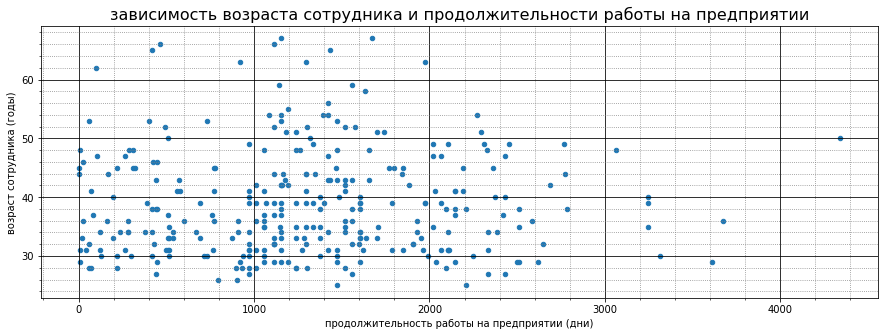

In [8]:
fig = plt.figure(figsize=(15,5))
ax = plt.axes()
ax.scatter(df_age_days_employed.days_work, df_age_days_employed.age, s= 20)


ax.xaxis.set_minor_locator(ticker.MultipleLocator(50))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.set_title('зависимость возраста сотрудника и продолжительности работы на предприятии', fontsize=16)
ax.set_xlabel('продолжительность работы на предприятии (дни)')
ax.set_ylabel('возраст сотрудника (годы)')


ax.grid(which='major',
        color = 'k')
ax.minorticks_on()
ax.grid(which='minor',
        color = 'gray',
        linestyle = ':')

Наибольшая плотность находится в промежутке от 900 до 2000 дней, и распределена равномерно, значимой разницы возраста от количества проработанных дней не наблюдается. От двух тысяч дней возраст работников начинает молодеть. После 3000 рабочих дней нет работников старше 50 лет. На отметке 4380 дней есть один работник возрастом 50 лет

### 4. Есть ли зависимость уровня зарплаты от расы работников

In [9]:
conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

sql_str = """
SELECT ROUND(avg("Pay Rate")) pay_rate,
       racedesc,
       count("racedesc")
FROM hr_dataset 
GROUP BY racedesc
ORDER BY pay_rate;
"""
conn.commit()
cursor.execute(sql_str)
df_race_pay =pd.DataFrame([a for a in cursor.fetchall()])
df_race_pay.columns = ['pay_rate', 'racedesc', 'count']
cursor.close()

df_race_pay

,pay_rate,racedesc,count
0,30.0,American Indian or Alaska Native,4
1,30.0,White,193
2,31.0,Two or more races,18
3,31.0,Asian,34
4,35.0,Black or African American,57
5,40.0,Hispanic,4


Работники латино-американцы в среднем получают больше других рас, но выборка из 4х человек не поволяет говорить точно. Посмотрим на должности и уровень ставки для этих 4х человек

In [10]:
conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

sql_str = """
SELECT "Pay Rate",
       racedesc,
       department,
       "position"
FROM hr_dataset 
WHERE racedesc = 'Hispanic';
"""
conn.commit()
cursor.execute(sql_str)
df_hispanic_pay =pd.DataFrame([a for a in cursor.fetchall()])
df_hispanic_pay.columns = ['pay_rate', 'racedesc', 'department', 'position']
cursor.close()

df_hispanic_pay

,pay_rate,racedesc,department,position
0,63.0,Hispanic,IT/IS,IT Manager - Infra
1,53.0,Hispanic,Production,Production Manager
2,17.0,Hispanic,Production,Production Technician I
3,26.0,Hispanic,Production,Production Technician II


У двоих человек из 4х ставка в два раза больше средней  по всем рассам. Соответственно судить о рассовой дискриминации не приходится

## 5. Изучим различные зависимости от статуса работника (Employment Status)

### 5.1 Есть ли зависимость количества уволенных сотрудников от департамента в котором они работали

In [11]:
conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

sql_str = """
SELECT count(id) count_employee,
       department,
       "Employment Status"
FROM hr_dataset 
WHERE "Employment Status" IN('Terminated for Cause', 'Voluntarily Terminated')
GROUP BY "Employment Status", department
ORDER BY department;
"""
conn.commit()
cursor.execute(sql_str)
df_fired_employee =pd.DataFrame([a for a in cursor.fetchall()])
df_fired_employee.columns = ['count_employee', 'department', 'Employment Status']
cursor.close()

df_fired_employee

,count_employee,department,Employment Status
0,2,Admin Offices,Voluntarily Terminated
1,4,IT/IS,Terminated for Cause
2,6,IT/IS,Voluntarily Terminated
3,8,Production,Terminated for Cause
4,75,Production,Voluntarily Terminated
5,3,Sales,Voluntarily Terminated
6,1,Sales,Terminated for Cause
7,2,Software Engineering,Voluntarily Terminated
8,1,Software Engineering,Terminated for Cause


Больше всего работников уволились добровольно в производственном отделе и были уволены по причине также в этом отделе. Возможно объясняется это высокой текучкой непрофильных работников, низкой оплатой труда и низкой замотивированностью к работе. Изучим возможные зависимости уровня ставки, среднего возраста от департамента:

In [12]:
conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

sql_str = """
SELECT department,
       count(id) count_employee,
       ROUND(avg("Pay Rate")),
       ROUND(avg(age)) age
FROM hr_dataset 
WHERE "Employment Status" IN('Terminated for Cause', 'Voluntarily Terminated')
GROUP BY department
ORDER BY department;
"""
conn.commit()
cursor.execute(sql_str)
df_fired_dep =pd.DataFrame([a for a in cursor.fetchall()])
df_fired_dep.columns = [ 'department','count_employee', 'pay', 'age']
cursor.close()

df_fired_dep

,department,count_employee,pay,age
0,Admin Offices,2,38.0,32
1,IT/IS,10,45.0,40
2,Production,83,23.0,40
3,Sales,4,56.0,44
4,Software Engineering,3,49.0,35


В производственном департаменте сильно отличается средняя ставка уволенных или уволившихся по сравнению с другими отделами. Зависимости от возраста не обнаружено. Стоит задуматься о подборе более профильного персонала в производственный отдел и о повышении ставки низкооплачиваемым работникам. Но обычно текучка непрофильного персонала это нормальное явление. 
Для подтверждения этой гипотезы, проверим как долго в среднем проработали уволенные или уволившиеся сотрудники по производственному отделу:

In [13]:
conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

sql_str = """
SELECT department,
       count(id) count_employee,
       ROUND(avg("Days Employed"))
FROM hr_dataset 
WHERE "Employment Status" IN('Terminated for Cause', 'Voluntarily Terminated')
GROUP BY department
ORDER BY department;
"""
conn.commit()
cursor.execute(sql_str)
df_fired_days =pd.DataFrame([a for a in cursor.fetchall()])
df_fired_days.columns = [ 'department','count_employee', 'days_employed']
cursor.close()

df_fired_days

,department,count_employee,days_employed
0,Admin Offices,2,1183
1,IT/IS,10,429
2,Production,83,793
3,Sales,4,935
4,Software Engineering,3,862


Гипотеза не подтвердилась, в среднем уволенные или уволившиеся работники проработали больше двух лет. Такое частое увольнение довольно опытных работников модет говорить как о низкой ставке, так и отсутствии замотивированности в виде карьерного роста, интересной работы, и прочее. HR отделу стоит обратить внимание на текучку кадров в производственном департаменте.

### 5.2 Есть ли зависимость уволенных работников от гендерной принадлежности:

In [14]:
conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

sql_str = """
SELECT department,
       round(count(id)) count_employed,
       sex
FROM hr_dataset
WHERE "Employment Status" IN('Terminated for Cause', 'Voluntarily Terminated')
GROUP BY sex, department
ORDER BY department;
"""
conn.commit()
cursor.execute(sql_str)
df_fired_sex =pd.DataFrame([a for a in cursor.fetchall()])
df_fired_sex.columns = [ 'department','count_employed', 'sex']
cursor.close()

df_fired_sex

,department,count_employed,sex
0,Admin Offices,1.0,Female
1,Admin Offices,1.0,Male
2,IT/IS,3.0,Female
3,IT/IS,7.0,Male
4,Production,32.0,Male
5,Production,51.0,Female
6,Sales,1.0,Male
7,Sales,3.0,Female
8,Software Engineering,2.0,Male
9,Software Engineering,1.0,Female


В производственном отделе женщины уволняются или были уволены чаще чем мужчины. Возможно это связано с процентным соотношением между мужчинами и женщинами в этом отделе. Посмотрим, так ли это:

In [15]:
conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

sql_str = """
SELECT department,
       round(count(id)) count_employed,
       sex
FROM hr_dataset
WHERE department IN('Production       ')
GROUP BY sex, department
ORDER BY department, sex;
"""
conn.commit()
cursor.execute(sql_str)
df_prod_sex =pd.DataFrame([a for a in cursor.fetchall()])
df_prod_sex.columns = [ 'department','count_employed', 'sex']
cursor.close()

df_prod_sex

,department,count_employed,sex
0,Production,127.0,Female
1,Production,81.0,Male


In [16]:
print('соотношение работающих женщин и мужчин = ', df_prod_sex.count_employed[0]/df_prod_sex.count_employed[1])
print('соотношение уволенных женщин и мужчин = ',df_fired_sex.count_employed[5]/df_fired_sex.count_employed[4])

соотношение работающих женщин и мужчин =  1.5679012345679013
соотношение уволенных женщин и мужчин =  1.59375


Как видно, мужчины и женщины увольняются в том же процентном соотношении  в котором они работают в производственном отделе. 

 ### 5.3 Есть ли зависимость между количеством уволенных или уволившихся людей и их семейным статусом - женатые и все остальные.

In [17]:
conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

sql_str = """
SELECT department,
       marriedid,
       round(count(id)) count_status
FROM hr_dataset
WHERE empstatus_id  IN(4,5)
GROUP BY marriedid, department
ORDER BY department;
"""
conn.commit()
cursor.execute(sql_str)
df_fires_married =pd.DataFrame([a for a in cursor.fetchall()])
df_fires_married.columns = [ 'department','married_id', 'count_ctatus']
cursor.close()

df_fires_married

,department,married_id,count_ctatus
0,Admin Offices,1,2.0
1,IT/IS,0,6.0
2,IT/IS,1,4.0
3,Production,0,46.0
4,Production,1,37.0
5,Sales,0,3.0
6,Sales,1,1.0
7,Software Engineering,1,1.0
8,Software Engineering,0,2.0


Очевидно, что неженатые, разведённые и прочие чаще увольняются чем женатые люди. Следует учитывать при подборе персонала, так как женатые люди по всей видимости больше дорожат и с большей ответственностью относятся к работе

### 5.4 Есть ли зависимость количества уволенных работников от менеджера:

In [18]:
conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

sql_str = """
SELECT department,
       "Manager Name",
       round(count(id)) count_status
FROM hr_dataset
WHERE empstatus_id  IN(4,5)
GROUP BY "Manager Name", department
ORDER BY department, count_status DESC;
"""
conn.commit()
cursor.execute(sql_str)
df_fires_manager =pd.DataFrame([a for a in cursor.fetchall()])
df_fires_manager.columns = [ 'department','manager_name', 'count_fired']
cursor.close()

df_fires_manager

,department,manager_name,count_fired
0,Admin Offices,Janet King,1.0
1,Admin Offices,Brandon R. LeBlanc,1.0
2,IT/IS,Simon Roup,8.0
3,IT/IS,Peter Monroe,1.0
4,IT/IS,Jennifer Zamora,1.0
5,Production,Amy Dunn,13.0
6,Production,Webster Butler,13.0
7,Production,Kissy Sullivan,12.0
8,Production,Michael Albert,9.0
9,Production,Elijiah Gray,8.0


У трёх менеджеров самые высокие показатели уволившихся, по 12-13 человек. Необходимо обратить на это внимание и выяснить в чём причины.

### 6. Есть ли зависимость уровня ставки от пола по департаментам:

In [19]:
conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

sql_str = """
SELECT department,
       sex,
       round(avg("Pay Rate")) avg_pay
FROM hr_dataset
GROUP BY department, sex
ORDER BY department;
"""
conn.commit()
cursor.execute(sql_str)
df_pay_sex_dep =pd.DataFrame([a for a in cursor.fetchall()])
df_pay_sex_dep.columns = [ 'department','sex', 'avg_pay']
cursor.close()

df_pay_sex_dep

,department,sex,avg_pay
0,Admin Offices,Female,26.0
1,Admin Offices,Male,40.0
2,Executive Office,Female,80.0
3,IT/IS,Male,48.0
4,IT/IS,Female,44.0
5,Production,Female,23.0
6,Production,Male,24.0
7,Sales,Male,55.0
8,Sales,Female,56.0
9,Software Engineering,Male,43.0


В административной части женщины получают явно меньше чем мужчины, скорее всего связано с занимаемыми должностями. в департаменте IT/IS мужчины получают немноо больше чем женщины. В  департаменте програмного обеспечения ставка у женщин примерно на 25% больше чем у мужчин, в продажах и производстве примерно одинаково.

### 7. Изучим с каких рекрутинговых площадок больше всего нанимаемых работников, и какая средняя ставка этих работников:

In [20]:
conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

sql_str = """
SELECT "Employee Source",
       round(count(id)) count_employed,
       round(avg("Pay Rate")) avg_pay
FROM hr_dataset
GROUP BY "Employee Source"
ORDER BY count_employed DESC, avg_pay;
"""
conn.commit()
cursor.execute(sql_str)
df_source_avg_pay =pd.DataFrame([a for a in cursor.fetchall()])
df_source_avg_pay.columns = [ 'employee_source','count_employed', 'avg_pay']
cursor.close()

df_source_avg_pay

,employee_source,count_employed,avg_pay
0,Employee Referral,31.0,36.0
1,Diversity Job Fair,29.0,29.0
2,Search Engine - Google Bing Yahoo,25.0,25.0
3,Monster.com,24.0,32.0
4,Pay Per Click - Google,21.0,40.0
5,Professional Society,20.0,31.0
6,Newspager/Magazine,18.0,24.0
7,MBTA ads,17.0,25.0
8,Billboard,16.0,30.0
9,Vendor Referral,15.0,41.0


Такие источники как 'Pay Per Click', 'On line Web application', 'Careerbuilder' в дальнейшем можно не рассматривать, так как эти площадки принесли только по одному низкооплачиваему работнику работнику. 

### 8. Есть ли зависимость между полом работника и продолжительностью работы на фабрике

In [21]:
conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

sql_str = """
SELECT sex, "Days Employed"
FROM hr_dataset
ORDER BY sex, "Days Employed" DESC;
"""
conn.commit()
cursor.execute(sql_str)
df_sex_days_employed =pd.DataFrame([a for a in cursor.fetchall()])
df_sex_days_employed.columns = [ 'sex','days_employed']
cursor.close()

df_sex_days_employed

,sex,days_employed
0,Female,3611
1,Female,3317
2,Female,3247
3,Female,3247
4,Female,3244
...,...,...
305,Male,164
306,Male,127
307,Male,125
308,Male,6


Теперь можно оценить насколько гендерная принадлежность влияет на продолжительность работы на предприятии. Создадим два облака точек. По оси "y" отложим значения продолжительности работы. Что бы облака точек гендерной принадлежности мужчин и женщин не сливались, по оси икс создадим два поля, одно для мужчин, второе для женщин. Тики на оси икс служат лишь для равномерного распределения точек в полях и не несут информации. Если разница в продолжительности работы между мужчинами и женщинами будет значительная, то мы увидим ,что одно облако выше другого.
Построим scatter plot, что бы увидеть есть ли зависимость продолжительности работы от пола:

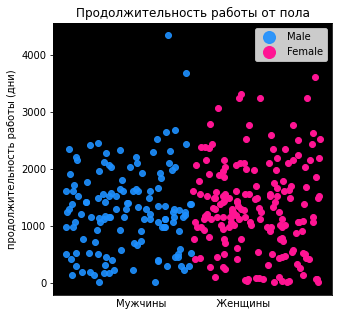

In [22]:
x1 = np.random.rand(133)
x2 = np.random.rand(177)


y1 = df_sex_days_employed[df_sex_days_employed.sex == 'Male']['days_employed']
y2 = df_sex_days_employed[df_sex_days_employed.sex == 'Female']['days_employed']
fig, ax = plt.subplots()

ax.scatter(x1, y1, c = 'dodgerblue', label='Male', alpha=0.9)
ax.scatter(x2 + 1, y2, c = 'deeppink', label='Female')

ax.set_facecolor('black')
ax.set_title('Продолжительность работы от пола')
ax.legend(markerscale=2)
ax.set_xlabel('Мужчины                Женщины')
ax.set_ylabel('продолжительность работы (дни)')
ax.set_xticks([])

fig.set_figwidth(5)    
fig.set_figheight(5)    

plt.show()

Средняя продолжительность работы мужчин и женщин примерно одинаковая. Есть 6 женщин работающих больше 3000 дней, их общая продолжительность может повлиять на среднюю продолжительность работы женщин на предприятии. Для проверки этого сгруппируем датафрейм по гендерной принадлежности и посчитаем среднюю продолжительность для каждого пола:

In [25]:
df_sex_days_employed.groupby(['sex'])['days_employed'].mean().reset_index()

,sex,days_employed
0,Female,1313.457627
1,Male,1272.954887


Повлияли ли эти 6 женщин на среднюю продолжительность работы, можно проверить убрав значения более 3000 дней:

In [26]:
df_sex_days_employed[df_sex_days_employed['days_employed'] < 3000]\
                    .groupby(['sex'])['days_employed'].mean().reset_index()

,sex,days_employed
0,Female,1244.157895
1,Male,1231.221374


Как видим, средняя продолжительность работы большинства женщин и мужчин практически одинаковая. Или в процентоном соотношении это будет:

In [27]:
(1244-1231) / (1244/100)

1.045016077170418

То есть продолжительность работы женщин на предприятии больше мужчин в среднем на 1%, что не является значительной разницей

## ИТОГИ:

**Нами были исследованы следующие зависимости:**
* Есть ли зависимость между perfomance score и тем, под чьим руководством работает сотрудник.
* Есть ли зависимость между продолжительностью работы в компании и семейным положением сотрудника.
* Есть ли зависимость между продолжительностью работы в компании и возрастом сотрудника.
* Есть ли зависимость уровня зарплаты от расы работников.
* Есть ли зависимость количества уволенных сотрудников от департамента в котором они работали.
* Есть ли зависимость уволенных работников от гендерной принадлежности.
* Есть ли зависимость между количеством уволенных или уволившихся людей и их семейным статусом - женатые и все остальные.
* Есть ли зависимость количества уволенных работников от менеджера.
* Есть ли зависимость уровня ставки от пола по департаментам.
* Изучим с каких рекрутинговых площадок больше всего нанимаемых работников, и какая средняя ставка этих работников.
* Есть ли зависимость между полом работника и продолжительностью работы на фабрике

**Выводы:**
Стоит обратить внимание на менеджеров Debra Houlihan, John Smith, Michael Albert так как их показатели производительности труда ниже чем в среднем по предприятию.
На предприятии относительно молодой коллектив, и молодые сотрудники больше по времени работают на предприятии. При найме работников необходимо делать упор на людей до 50 лет.
Рассовой дискриминации на предприятии не наблюдается. 
В производственном отделе наблюдается большее количесвто уволнений чем в среднем по предприятию, причём уволеные в основном проработали около двух лет, причиной увольнения могут являться низкая ставка, высокая загруженность на производстве, отсутствие или сложности в продвижении по карьере, нездоровая обстановка внутри коллектива. Необходимо обратить внимание на производственный отдел.
Такие рекрутинговые источники как 'Pay Per Click', 'On line Web application', 'Careerbuilder' в дальнейшем можно не рассматривать, так как эти площадки принесли только по одному низкооплачиваему работнику работнику.
Дискриминация по половому признаку на пердприятии не наблюдается.

***

## Часть вторая

Перед вами стоит задача – подготовить аналитический ответ для SMM-отдела компании Skillbox. <br> Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education). <br> <br> 
Подключитесь к  API VK и выгрузите посты со стены паблика Skillbox за интересующий период (определите самостоятельно и обоснуйте). Проанализируйте влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Сделайте аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике. Выбрать нужные посты можно с помощью регулярных выражений. Составьте перечень рекомандаций для SMM-отдела по итогам анализа. <br> <br> 

Дополнительные инструкции по работе с API VK расположены [здесь](https://nbviewer.jupyter.org/github/vikaborel/dstutorials/blob/master/Дополнительные%20инструкции.ipynb).

In [23]:
import requests
import time
from datetime import datetime, timedelta
def getjson(url):
    response = requests.get(url)
    response = response.json()
    return response


In [24]:
# Получаем токен:

vk_token = '103a880ec6c3d229591f8956aa15cb2789e318500dfb2303cc08fdfd95ae81aa0f00f7d6a397c53351a18'

response = {}
# Создаём запрос, и получаем всю информацию со стены сообщества, количеством 1000 записей. 
# В  данном случае конкретный год или месяц нам не интересен, а интересен период за один год,
# для анализа активности в течении года.

for j in range(10):
    y = (j+1)*100
    x = j*100
    while x < y:
        url = 'https://api.vk.com/method/wall.get?access_token='\
        + str(vk_token)\
        + '&owner_id=-66669811&offset='\
        + str(x)\
        +'&count=1&v=5.120'
        response[x] = getjson(url)
        x += 1
        time.sleep(0.34)


In [25]:
убедимся что мы собрали данные по 1000 записям на стене сообщества:

len(response)

1000

In [26]:
Создадим пустой датасет, который в дальнейшем будем  заполнять результатами нашего запроса:

df_skillbox_public = pd.DataFrame(columns=['title_publication', 
                                   'count_likes', 
                                   'count_comments', 
                                   'count_reposts', 
                                   'count_views', 
                                   'date_publication'])


In [92]:
Заполним созданный датасет результатами нашего запроса, 
в случае отсутствия для конкретной записи позиции: response/items/attachments/link/title,
заменим наименование темы записи на стене сообщества текстом самого поста.
также преобразуем  данные поля 'date_publication' в объект datetime и на его основе создадим два поля даты и времени:

for i in range(len(response)):
    try:
        title = response[i]['response']['items'][0]['attachments'][0]['link']['title']
    except KeyError:
        title = response[i]['response']['items'][0]['text']
    likes = response[i]['response']['items'][0]['likes']['count']
    comments = response[i]['response']['items'][0]['comments']['count']
    reposts = response[i]['response']['items'][0]['reposts']['count']
    views = response[i]['response']['items'][0]['views']['count']
    date = response[i]['response']['items'][0]['date']
    date_publication = (datetime.fromtimestamp(date) - timedelta(hours=0)).strftime('%Y-%m-%d %H:%M:%S')
    row = [title, likes, comments, reposts, views, date_publication]
    df_skillbox_public.loc[i] = row

        
df_skillbox_public['date_publication'] = pd.to_datetime(df_skillbox_public['date_publication'])   
df_skillbox_public['date'] = pd.to_datetime(df_skillbox_public['date_publication'].dt.date)
df_skillbox_public['time'] = df_skillbox_public['date_publication'].dt.time

In [ ]:
сохраним наш датасет для дальнейшей работы с ним без постоянного обращения к запросам AVI VK:

df_skillbox_public = df_skillbox_public.to_csv('./Data/df_skillbox', sep=',')

In [29]:
# откроем наш датасет:

df_skillbox = pd.read_csv('./Data/df_skillbox')
df_skillbox = df_skillbox.drop('Unnamed: 0', axis=1)

In [30]:
df_skillbox

,title_publication,count_likes,count_comments,count_reposts,count_views,date_publication,date,time
0,"Дизайнеры, собрали для вас бесплатные сервисы,...",67,0,21,8961,2020-08-10 11:18:35,2020-08-10,11:18:35
1,YouTube-каналы могут научить многому: рисовать...,199,0,34,20103,2020-08-09 11:15:16,2020-08-09,11:15:16
2,"В дизайне много направлений: UX/UI, веб, моуше...",120,0,10,18088,2020-08-08 11:00:43,2020-08-08,11:00:43
3,Все UX-дизайнеры мира точно захотят сказать сп...,143,12,15,19981,2020-08-07 11:42:50,2020-08-07,11:42:50
4,"Что такое баги, ворнинги и исключения в програ...",22,0,2,15508,2020-08-06 18:21:20,2020-08-06,18:21:20
...,...,...,...,...,...,...,...,...
995,Представляем вам шрифт Lena! \n\nLena спроекти...,229,11,27,33262,2019-04-12 17:30:02,2019-04-12,17:30:02
996,Как научиться рисовать набросок человека,51,0,7,8030,2019-04-12 12:53:47,2019-04-12,12:53:47
997,Как пользоваться SEO-ссылками и остаться в выдаче,28,0,6,7603,2019-04-11 19:30:03,2019-04-11,19:30:03
998,Самое главное в разработке мобильного приложен...,56,0,18,9411,2019-04-11 17:30:02,2019-04-11,17:30:02


### 1. Изучим датасет на предмет количества лайков, просмотров, репостов, комментариев

In [31]:
# Посмотрим первые 10 записей с наибольшим количеством просмотров. Как видим, по большей части, это темы касающиеся дизайна.

df_skillbox.sort_values('count_views', ascending=False).head(10)

,title_publication,count_likes,count_comments,count_reposts,count_views,date_publication,date,time
497,Вы дизайнер и не боитесь правок от заказчика? ...,68,34,3,122771,2019-11-10 12:35:11,2019-11-10,12:35:11
892,#OFFF_конкурс \n \nЕсли ты крутой дизайнер и н...,198,44,12,95798,2019-05-20 13:10:08,2019-05-20,13:10:08
157,[club163456906|TEDxDvortsovayaSquare] и Skillb...,888,802,169,88600,2020-05-13 16:32:38,2020-05-13,16:32:38
852,Выпускники с заслуженными дипломами и новыми к...,137,6,1,76612,2019-06-02 15:30:00,2019-06-02,15:30:00
779,"Сегодня вы придете домой уставшим, приготовите...",157,30,18,74589,2019-07-04 18:30:02,2019-07-04,18:30:02
167,"Срочно нужна анимация в соцсети, а у дизайнера...",935,20,180,69196,2020-05-06 12:20:16,2020-05-06,12:20:16
357,Пока нейросети учатся самостоятельно снимать к...,350,22,64,67730,2020-01-22 12:01:41,2020-01-22,12:01:41
853,В это воскресенье собрали для вас мастер-класс...,796,9,232,67547,2019-06-02 10:30:00,2019-06-02,10:30:00
380,"Вас устраивает, что в сутках всего 24 часа? И ...",440,17,73,67350,2020-01-11 12:23:07,2020-01-11,12:23:07
316,"Нужна картинка для соцсетей, а Photoshop нет п...",611,0,109,62817,2020-02-11 12:22:05,2020-02-11,12:22:05


In [32]:
# Посмотрим первые 10 записей с наибольшим количеством лайков. Как видим, это снова темы связанные с дизайном.

df_skillbox.sort_values('count_likes', ascending=False).head(10)

,title_publication,count_likes,count_comments,count_reposts,count_views,date_publication,date,time
167,"Срочно нужна анимация в соцсети, а у дизайнера...",935,20,180,69196,2020-05-06 12:20:16,2020-05-06,12:20:16
157,[club163456906|TEDxDvortsovayaSquare] и Skillb...,888,802,169,88600,2020-05-13 16:32:38,2020-05-13,16:32:38
853,В это воскресенье собрали для вас мастер-класс...,796,9,232,67547,2019-06-02 10:30:00,2019-06-02,10:30:00
442,"Дизайнеры, отвлекитесь от игр со шрифтами. Лов...",643,5,129,51440,2019-12-04 19:00:01,2019-12-04,19:00:01
316,"Нужна картинка для соцсетей, а Photoshop нет п...",611,0,109,62817,2020-02-11 12:22:05,2020-02-11,12:22:05
311,"Дизайнеры, собрали для вас сайты, где можно бе...",540,4,93,54005,2020-02-13 11:59:51,2020-02-13,11:59:51
230,Работа из дома требует большой самодисциплины....,534,2,75,55355,2020-03-28 20:00:09,2020-03-28,20:00:09
965,Эта воскресная подборка вебинаров по программи...,525,4,106,44945,2019-04-21 10:30:00,2019-04-21,10:30:00
894,В это воскресенье собрали для вас 10 свежих ма...,507,6,110,50953,2019-05-19 10:30:00,2019-05-19,10:30:00
296,Слышали про метод шести шляп? Это крайне полез...,481,0,73,61650,2020-02-21 12:20:45,2020-02-21,12:20:45


In [33]:
# Большее количество репостов также связано с дизайном, а также с различными подборками полезной информации:

df_skillbox.sort_values('count_reposts', ascending=False).head(10)

,title_publication,count_likes,count_comments,count_reposts,count_views,date_publication,date,time
853,В это воскресенье собрали для вас мастер-класс...,796,9,232,67547,2019-06-02 10:30:00,2019-06-02,10:30:00
167,"Срочно нужна анимация в соцсети, а у дизайнера...",935,20,180,69196,2020-05-06 12:20:16,2020-05-06,12:20:16
157,[club163456906|TEDxDvortsovayaSquare] и Skillb...,888,802,169,88600,2020-05-13 16:32:38,2020-05-13,16:32:38
442,"Дизайнеры, отвлекитесь от игр со шрифтами. Лов...",643,5,129,51440,2019-12-04 19:00:01,2019-12-04,19:00:01
894,В это воскресенье собрали для вас 10 свежих ма...,507,6,110,50953,2019-05-19 10:30:00,2019-05-19,10:30:00
316,"Нужна картинка для соцсетей, а Photoshop нет п...",611,0,109,62817,2020-02-11 12:22:05,2020-02-11,12:22:05
925,Подборку мастер-классов этой недели мы посвяти...,300,3,108,47098,2019-05-05 10:30:00,2019-05-05,10:30:00
965,Эта воскресная подборка вебинаров по программи...,525,4,106,44945,2019-04-21 10:30:00,2019-04-21,10:30:00
991,Эта подборка мастер-классов расскажет вам всё ...,382,2,105,34619,2019-04-14 10:30:00,2019-04-14,10:30:00
311,"Дизайнеры, собрали для вас сайты, где можно бе...",540,4,93,54005,2020-02-13 11:59:51,2020-02-13,11:59:51


In [34]:
df_skillbox['date_publication'] = pd.to_datetime(df_skillbox['date_publication'])
df_skillbox['date'] = pd.to_datetime(df_skillbox['date'])

### 2. Изучим темы на странице Skillbox с наибольшими просмотрами:

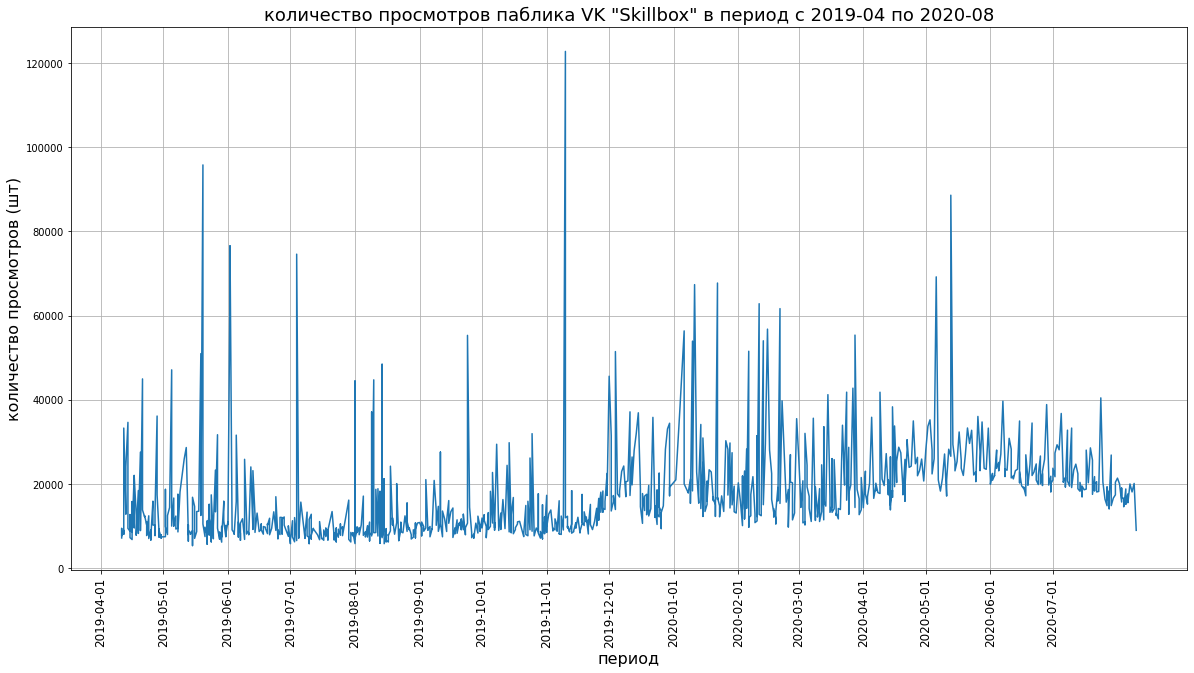

In [84]:
# Построим график количества просмотров тем на стене сообщества, за период с 2019-04-01 по 2020-07-01.

df = df_skillbox.sort_values('date')
x = df.date
y = df.count_views
z = np.arange('2019-04', '2020-08', dtype='datetime64[M]')
fig = plt.figure(figsize=(20,10))



plt.plot(x, y)
plt.xticks(z, rotation='vertical',fontsize=12)
plt.title('количество просмотров паблика VK "Skillbox" в период с 2019-04 по 2020-08', fontsize=18)
plt.xlabel('период', fontsize=16)
plt.ylabel('количество просмотров (шт)', fontsize=16)
plt.grid()

В период с 2019-04-01 по 2019-12-01 просомтры в среднем держались примерно на одном уровне около 10000 просомтров на каждую тему, кроме  определённых тем с гораздо большими просмотрами ( разберём их далее). С 2019-12-01 по 2020-07-01 количестов просмотров тем увеличилось в среднем до 20000 с просадками в феврале и марте и подъёмом в мае и июне. На графике видно, что увелечение среднего количества просмотров с 10000 до 20000 началось примерно после опубликования на странице темы с просмотром более 120000. Найдём эту тему и разберём её отдельно.

In [36]:
# Посмотрим на темы публикаций количество просмотров которых больше 70000:

df_skillbox[df_skillbox['count_views'] >= 70000].sort_values('count_views', ascending=False)

,title_publication,count_likes,count_comments,count_reposts,count_views,date_publication,date,time
497,Вы дизайнер и не боитесь правок от заказчика? ...,68,34,3,122771,2019-11-10 12:35:11,2019-11-10,12:35:11
892,#OFFF_конкурс \n \nЕсли ты крутой дизайнер и н...,198,44,12,95798,2019-05-20 13:10:08,2019-05-20,13:10:08
157,[club163456906|TEDxDvortsovayaSquare] и Skillb...,888,802,169,88600,2020-05-13 16:32:38,2020-05-13,16:32:38
852,Выпускники с заслуженными дипломами и новыми к...,137,6,1,76612,2019-06-02 15:30:00,2019-06-02,15:30:00
779,"Сегодня вы придете домой уставшим, приготовите...",157,30,18,74589,2019-07-04 18:30:02,2019-07-04,18:30:02


In [37]:
df_title = df_skillbox[df_skillbox['count_views'] >= 70000].sort_values('count_views', ascending=False)['title_publication']
df_title

497    Вы дизайнер и не боитесь правок от заказчика? ...
892    #OFFF_конкурс \n \nЕсли ты крутой дизайнер и н...
157    [club163456906|TEDxDvortsovayaSquare] и Skillb...
852    Выпускники с заслуженными дипломами и новыми к...
779    Сегодня вы придете домой уставшим, приготовите...
Name: title_publication, dtype: object

In [101]:
# Получилось 5 тем. Рассмотрим описание каждой из них, что бы понять что в них есть общего, 
# что могло привелечь внимание гораздо большее, чем внимание к другим темам.
for row in df_title.index:
    print('\n ------------индекс темы: {}-------------\n'.format(row))
    print(df_title[row])


 ------------индекс темы: 497-------------

Вы дизайнер и не боитесь правок от заказчика? Примите наш вызов!

Гости фестиваля «Среда» оставили замечания к макетам Райффайзенбанка, Ozon и Рокетбанка. Мы предлагаем вам внимательно изучить правки и внести как можно больше из них в клиентские макеты. 

Авторы лучших работ получат билеты на фестиваль «OFFF Moscow 2020» и подарки от Skillbox и партнеров Среды. 

Прием работ открыт. Присылайте их в комментариях под этим постом до 31 ноября включительно.

Узнать подробности конкурса и скачать исходники макетов можно по ссылке: https://events.skillbox.ru/skillboxsreda

#Skillbox_Sreda #Skillbox_конкурс

 ------------индекс темы: 892-------------

#OFFF_конкурс 
 
Если ты крутой дизайнер и не боишься замечаний заказчика — прими наш вызов! 
 
Переделай клиентские макеты по комментариям, которые оставили гости OFFF Moscow 2019. Задача — максимально внести все замечания и сделать приличную работу. 
 
Зачем участвовать в конкурсе: 
— Из-за призов. 

Предварительно можно сказать что ключевыми тригерами привлекающими внимание во всех пяти темах являются участие в конкурсах, подарки, призы и бесплатный доступ к курсам Skilbox, а также эти темы связаны в основном с дизайном. Изучим 10 других тем с наименьшими просмотрами, на исключение возможного варианта, где в каждой теме есть подарки и призы. Тогда можно будет сделать однозначный вывод на влияние "бесплатных плюшек" на количество просмотров. Исключим предварительно из датасета темы опубликованные недавно, оставив только темы опубликованные до 01 июля, так как новые темы просто могли ещё не набрать достаточное количество просмотров. 

In [102]:
df_title_minviews = df_skillbox[df_skillbox['date'] <= '2020-07-01']\
                    .sort_values('count_views', ascending=True)['title_publication']\
                    .head(5)

In [103]:
df_title_minviews

905    Ибран Трассиерра и Марчелло Буселли, дизайнеры...
887    Дмитрий Глазырин, преподаватель курса «Рекламн...
788    Ежедневно наши преподаватели выходят в прямой ...
680    В конце второго дня фестиваля в лектории Skill...
766    Если вы хотите стать разработчиком, Python — о...
Name: title_publication, dtype: object

Рассмотрим описательную часть некоторых полученных тем:

In [106]:
for text in df_title_minviews.index:
    print('\n----------------индекс темы: {} ----------------\n'.format(text))
    print(df_title_minviews[text])



----------------индекс темы: 905 ----------------

Ибран Трассиерра и Марчелло Буселли, дизайнеры из барселонской студии Device, приглашают тебя на OFFF Moscow! 

Если ты до сих пор не купил билет — у тебя есть последний шанс это сделать, причем, со скидкой 25%. 

Введи OFFF_SMM на странице регистрации, чтобы купить билет дешевле: https://skillbox.timepad.ru/event/875357. Важно: сегодня после 20:00 продажа билетов закрывается — торопись!

И не забудь подписаться на Инстаграм события — в сторис мы будем делиться новостями с площадки: https://instagram.com/offfmoscow.

----------------индекс темы: 887 ----------------

Дмитрий Глазырин, преподаватель курса «Рекламная Графика», вновь поделился впечатляющей работой, созданной специально для города Рио-де-Жанейро. Хотели бы видеть такую социальную рекламу в своем городе? 

Курс, на котором вы научитесь создавать крутую рекламную графику: https://vk.cc/9pVuKE

----------------индекс темы: 788 ----------------

Ежедневно наши преподаватели в

Итак, как видим, хоть в этих темах предлагаются вебинары или полезная информация, но нет "бесплатных плюшек", что может влиять на количество просмотров, также выявляется определённая связь количества просмотров и людей интересующихся дизайном. Попробуем с помощью регулярных выражений, найти темы в которых есть слова: "подарки, призы, конкурс, бесплатно" и изучить медианное  количество просмотров в темах где такие слова встречаются т в темах где таких слов нет.

In [53]:
reg = [r'\b\подар\w+', r'\b\приз\w+', r'\b\конкурс\w+', r'\b\бесплатн\w+']
regx = '|'.join(reg)
df_skillbox = df_skillbox.dropna()
df_title_bonus = df_skillbox[df_skillbox['title_publication'].str.contains(regx)]

In [54]:
df_title_bonus

,title_publication,count_likes,count_comments,count_reposts,count_views,date_publication,date,time
0,"Дизайнеры, собрали для вас бесплатные сервисы,...",67,0,21,8961,2020-08-10 11:18:35,2020-08-10,11:18:35
7,"В жизни каждого художника случаются истории, к...",33,0,0,15169,2020-08-05 13:22:25,2020-08-05,13:22:25
10,Время от времени просматриваете рекламные кейс...,53,9,9,16616,2020-08-04 12:14:13,2020-08-04,12:14:13
21,Как внедрить Data-Driven-подход? Где находить ...,22,0,2,16589,2020-07-30 11:04:01,2020-07-30,11:04:01
25,"Продолжаем серию лекций «Дизайн, философия и к...",25,11,1,14089,2020-07-28 15:56:08,2020-07-28,15:56:08
...,...,...,...,...,...,...,...,...
870,26 бесплатных фотостоков в помощь дизайнеру,308,0,62,31678,2019-05-27 20:20:03,2019-05-27,20:20:03
892,#OFFF_конкурс \n \nЕсли ты крутой дизайнер и н...,198,44,12,95798,2019-05-20 13:10:08,2019-05-20,13:10:08
933,"Вам нужны статьи в блог, продающие тексты, опи...",18,0,2,7390,2019-04-30 21:30:01,2019-04-30,21:30:01
957,Наш совместный с Possible проект «Beware of Bo...,14,0,1,7275,2019-04-24 15:37:38,2019-04-24,15:37:38


Для сравнения количества просмотров в темах где присутствуют "плюшки" и где таковых нет, создадим датасет с исключёнными темами  полученными ранее:

In [55]:
drop_index = df_title_bonus.index
df_title_nobonus = df_skillbox.drop(drop_index)

Срвним медианные значения для двух полученных  датасетов с бонусами и без них:

In [56]:
df_title_bonus['count_views'].median()

17261.0

In [57]:
df_title_nobonus['count_views'].median()

13173.0

In [58]:
#Проверим, совпадает ли сумма строк в обоих датасетах с изначальным датасетом:

len(df_skillbox) == len(df_title_bonus) + len(df_title_nobonus)

True

Как видим медианное значение просмотров тем с бонусами больше чем просмотры тем без бонусов. Рассмотрим распределение просмотров по двум датасетам на графике. Для этого построим два облака точек для пабликов с предлагаемыми бонусами и для пабликов без бонусов. На оси "y" отложим значения количества просмотров тем, по оси икс распределим все 1000 тем, для простоты распределим их согласно их индексам. При значительной разнице в количестве просмотров, одно облако будет выше другого:

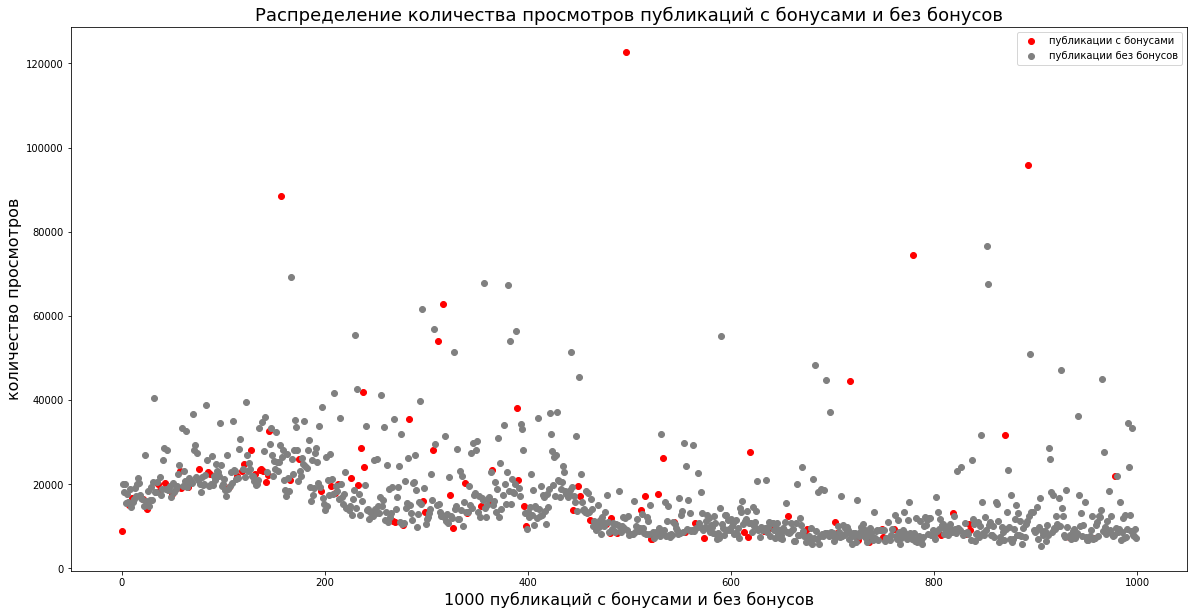

In [87]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

y = df_title_bonus['count_views']
x = df_title_bonus.index

Y = df_title_nobonus['count_views']
X = df_title_nobonus.index

ax.scatter(x, y, color = 'red', label='публикации с бонусами')
ax.scatter(X, Y, color = 'grey', label='публикации без бонусов')
ax.set_xlabel('1000 публикаций с бонусами и без бонусов', fontsize=16)
ax.set_ylabel('количество просмотров', fontsize=16)
ax.set_title('Распределение количества просмотров публикаций с бонусами и без бонусов', fontsize=18)
ax.legend()

plt.show()

Как видно из графика, большой вклад в увеличение медианного значения для датасета с бонусами вносят выбросы. Особо выраженной разницы между двумя датасетами не наблюдается. Попробуем изучить гипотезу в которой темы касающиеся дизайна более просматриваемы чем темы не про дизайн:

In [60]:
reg_design = [r'\b\дизайн\w+']
df_title_design = df_skillbox[df_skillbox['title_publication'].str.contains(r'\b\дизайн\w+')]

In [61]:
df_title_design['count_views'].median()

13379.0

In [62]:
# Сравним медианное значение для тем по дизайну и тем по дизайну с бонусами:

df_t = df_title_bonus[df_title_bonus['title_publication'].str.contains(r'\b\дизайн\w+')]

In [63]:
df_t['count_views'].median()

15371.5

Медианное значение может быть больше опять таки из-за выбросов, но нельзя не отметить присутствие влияние бонусов на количество просмотров

Проверим гипотезу, в которой утверждается что количество просмотров коррелируется с темами в которых упоминаются партнёры, фестивали и различные события:

In [64]:
reg = [r'.....\SMM\b', r'\b\фестивал\w+', r'\b\партнер\w+', r'\b\партнёр\w+']
reg_coloboration = '|'.join(reg)
df_skillbox = df_skillbox.dropna()
df_title_coloboration = df_skillbox[df_skillbox['title_publication'].str.contains(reg_coloboration)] 


In [66]:
df_title_coloboration['count_views'].median()

9912.0

Видно что наличие партнёров не вносит влияния на количество просмотров.

### 3. Изучим слова  встречающиеся в темах с количеством просмотров более 40000

Попробуем найти общие чаще всего встречающиеся слова для тем в которых количество слов больше 40000, именно в этом диапазоне наблюдаются самые большие количества просмотров:

In [67]:
df_big_count_views = df_skillbox[df_skillbox['count_views'] >= 40000]
# разбиваем тест на слова
corpus = []
# регулярка для поиска слов
regular_expr = r'\w{3,}'
reg_expr_compiled = re.compile(regular_expr)
# формируем датасет из отдельных слов
for raw_text in df_big_count_views['title_publication']:
    # приводим к нижнему регистру
    raw_text_lower = raw_text.lower()
    # разбиваем текст на слова
    text_by_words = reg_expr_compiled.findall(raw_text_lower) 
    corpus.append(text_by_words)

# нормализация текста
normalized_corpus = []
morph = pymorphy2.MorphAnalyzer()
# нормализуем каждое слово в тексте
for token_list in corpus:
    normalized_token_list = []
    for word in token_list:
        parsed_token = morph.parse(word)
        normal_form = parsed_token[0].normal_form
        normalized_token_list.append(normal_form)
    normalized_corpus.append(normalized_token_list)

# превращаем в DataFrame
doc_count = len(normalized_corpus)
doc_ids = []
tokens = []
# формируем два списка-колонки датафрейма
for doc_id in range(doc_count):
    for token in normalized_corpus[doc_id]:
        doc_ids.append(doc_id)
        tokens.append(token)

tokens_df = pd.DataFrame({
    'doc_id': doc_ids,
    'word': tokens
})
# дамми-столбец
tokens_df = tokens_df.assign(dummy = 1)
# аггрегируем статистики
word_count_df = tokens_df.groupby(['doc_id','word'])['dummy'].count().reset_index()
word_count_df.sort_values(by='dummy', ascending=False).head(10)

,doc_id,word,dummy
518,11,для,9
1164,23,фестиваль,6
582,11,сервис,5
526,11,изображение,4
422,9,палец,4
1021,21,это,4
323,7,реклама,3
1118,23,комментарий,3
399,9,клавиатура,3
400,9,клавиш,3


Теперь у нас есть датасет в котором у каждой темы есть свой id  и в каждом id есть только уникальные слова и их количества. Нас интересуют не столько частотность встречаемости того или иного слова, сколько встречаемость опредеоённого слова в каждом id. То есть мы можем найти какие слова объеденяют темы с самыми большими просмотрами. Для каждого id слова в датасете уникальны, но в разных id могут встречаться одни и те же слова. Подсчитаем количества одних и тех же слов встречающиеся во всех интересующих нас темах.

In [68]:
word_list = list(word_count_df.word)

In [69]:
# список всех предлогов, частиц, местоимений и слов которые могут встречаться в любой теме, 
# и слова не несущие определённого смысла:
trash_list = ['без', 'для', 'над', 'под', 'пред', 'перед', 'при', 'про', 'через',           
              'погодя', 'около', 'после' , 'возле' , 'мимо' , 'внутри' , 'вдоль' , 'вдали',
               'чтобы' , 'если', 'потому', 'что', 'кто', 'как', 'будто', 'есть', 'куда',
              'никуда', 'также', 'так', 'или', 'либо', 'однако', 'зато', 'этот', 'тот', 'который', 'ведь', 'весь',
              'это', 'чем', 'кем', 'кому', 'чему', 'для', 'затем', 'наш', 'ваш', 'он', 'вот',
              'она', 'они', 'сам', 'сама', 'свой', 'себя', 'себе', 'мой', 'твой', 'мне ', 'тебе', 'вам', 'будто', 
              'быть', 'вы', 'другой', 'как', 'мочь', 'только', 'надо', 'какой', 'https', 'сайт', 'пост', 'смотреть',
              'skillbox', 'один', 'можно', 'сделать', 'очень', 'ещё', 'каждый', 'даже', 'в_закладки_skillbox', 'нет',
              'делать', 'всего', 'день', 'комментарий'
             ]

# отфильтруем наш список от ненужных слов:

word_list_true = list()
for word in word_list:                                    
    if  word not in trash_list:  
        word_list_true.append(word)


In [70]:
# Посчитаем количество уникальных слов:

word_counts = defaultdict(int)
for word in word_list_true:
    word_counts[word] +=1
df_word_counts = pd.DataFrame(columns=['word', 'count'])
df_word_counts.word = word_counts.keys()
df_word_counts['count'] = word_counts.values()

In [71]:
#Количество уникальных слов для тем с большими просмотрами
len(df_word_counts)

786

In [72]:
df_word_counts.sort_values('count', ascending = False).head(30)

,word,count
102,карточка,10
151,работа,10
308,собрать,7
98,skillbox_дизайн,7
100,дизайнер,7
9,время,6
107,подборка,6
122,новый,5
111,сервис,5
82,поделиться,4


Из получившегося датасета видно, что общими посылами в темах с самым большим количеством просмотром являются посылы к получению нового, получению работы, к желанию научиться, к нужным знаниям и скилам, также посылы о том что сотрудники Skilbox  постарались и собрали интересные подборки. Также несколько раз встречаются слова с корнем дизайн, значит всё таки какую-то роль в количестве просмотров играет тема дизайна, видимо самая интересная для потенциальных студентов. 

### 4. Изучим влияние времени суток на посещение страницы Skillbox:

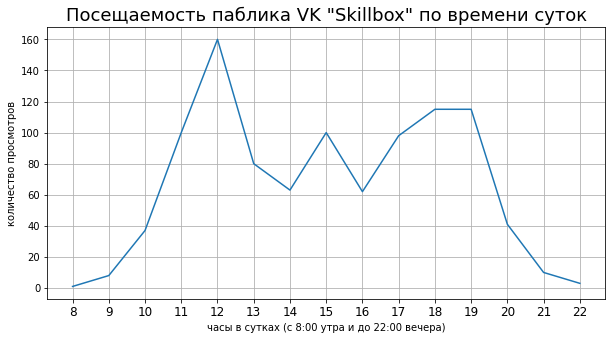

In [107]:
df = df_skillbox.date_publication\
                .dt\
                .hour\
                .value_counts()\
                .sort_index()

x = df.index
y = df.values
fig = plt.figure(figsize=(10,5))

plt.plot(x, y)
plt.xticks(x,fontsize=12)
plt.title('Посещаемость паблика VK "Skillbox" по времени суток', fontsize=18)
plt.xlabel('часы в сутках (с 8:00 утра и до 22:00 вечера)')
plt.ylabel('количество просмотров')
plt.grid()

Как и ожидалось, чаще всего страницу посещают в районе обеда (11-13 часов) и после рабочего дня (16-19 часов) Причём пиковое вечернее время приходится 18 часов, в это время обычно люди только возвращаются с работы домой, что может говорить о том что большее посещение сайта происходит с мобильных телефонов. Также пиковые точки в обеденное время и вечером могут говорить о том,  что бОльшая часть людей интересующихся новой професией или повышением квалификации уже работают или учатся. Возможно существуют методы привлечения именно этих двух категорий к обучению. Так как работающие или учащиеся, бОльшую часть времени заняты на работе или в образовательных учреждениях, то привлекающими способами могут быть короткие ролики с сжатыми тезисами, о гарантированном трудоустройстве, о возможности обучения по вечерам и выходным, и живыми примерами людей, одновременно работающих и учащихся в Скилбокс. Так как многие из приходящих на страницу Скилбокс, судя по всему повышают квалификацию, то хорошим методом привлечения этой категории могли бы являться тесты на уже имеющиеся знания и подбор программы в соответствии с имеющимися знаниями.

# Итоги:

При исследовании различных постов на странице Скилбокс выявились более интересные темы для посещающих сайт людей, это всё что связанно с дизайном, фестивалями и темами где предлагаются различные бонусы и подарки. Нельзя сказать что замеченные корреляции ярко выражены, но отличия в количестве посещений заметны. Так же выяснилось, что в самых популярных темах делается упор на донесении мысли о новых знаниях, о получении новых скилов, также хорошим методом привлечения является проведение конкурсов с раздачей подарков и призов. Всегда интересно поучавствовать в конкурсе или соревновании, тем более если есть призы. Но также та часть конкурсантов, которая не получила призов, всё равно является вовлечённой в процесс и с большей долей вероятности купит программу обучения, так как уже вовлечена и заинтересована. Также стоит делать упор на своместное проведение семинаров, фестивалей, и прочего. Так как коллаборации всегда являются источниками новых участников и могут привести на площадку многих людей. На такие выводы наталкивает количество просмотров, лайков и репостов в теме фестиваля "Среда" где партнёрами были известные банки и Озон. количество просмотров - 122000 говорит само за себя. Привлечение крупных компаний положительно влияет на прирост посещений страницы. Совместные программы по обучению (или повышению квалификации) специалистов с дальнейшим привлечением их в крупные компании может в разы увеличить количество студентов.
Наибольшее количество посещений страницы Скилбокс по времени суток говорит о вовлечённости в большей своей массе работающих и учащихся людей, что стоит учитывать и продумывать тригеры позволяющие заинтересовать именно эти категории - доступность, лёгкость обучения, возможность обучения в свободное время. Также различные тесты на имеющиеся знания и возможно, выдача сертификатов о повышении квалификации, для тех кто заинтересован именно в повышении квалификации.
С декабря 2019 года увеличилось медианное количество посещения страницы Скилбокс. Необходимо проанализировать, что в тот период могло являться побуждающей мотивацией для инетересующихся лиц.